In [151]:
from nhlpy import NHLClient
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from ydata_profiling import ProfileReport

In [3]:
client = NHLClient()

In [4]:
teams = client.teams.teams_info()
teams

[{'conference': {'abbr': 'W', 'name': 'Western'},
  'division': {'abbr': 'C', 'name': 'Central'},
  'name': 'Winnipeg Jets',
  'common_name': 'Jets',
  'abbr': 'WPG',
  'logo': 'https://assets.nhle.com/logos/nhl/svg/WPG_light.svg',
  'franchise_id': 35},
 {'conference': {'abbr': 'E', 'name': 'Eastern'},
  'division': {'abbr': 'M', 'name': 'Metropolitan'},
  'name': 'New Jersey Devils',
  'common_name': 'Devils',
  'abbr': 'NJD',
  'logo': 'https://assets.nhle.com/logos/nhl/svg/NJD_light.svg',
  'franchise_id': 23},
 {'conference': {'abbr': 'E', 'name': 'Eastern'},
  'division': {'abbr': 'M', 'name': 'Metropolitan'},
  'name': 'Washington Capitals',
  'common_name': 'Capitals',
  'abbr': 'WSH',
  'logo': 'https://assets.nhle.com/logos/nhl/svg/WSH_secondary_light.svg',
  'franchise_id': 24},
 {'conference': {'abbr': 'W', 'name': 'Western'},
  'division': {'abbr': 'P', 'name': 'Pacific'},
  'name': 'Vegas Golden Knights',
  'common_name': 'Golden Knights',
  'abbr': 'VGK',
  'logo': 'http

In [5]:
team_abbrs = []
for item in teams:
    abbr = item['abbr']
    team_abbrs.append(abbr)

In [6]:
team_abbrs

['WPG',
 'NJD',
 'WSH',
 'VGK',
 'TOR',
 'FLA',
 'MIN',
 'LAK',
 'EDM',
 'CAR',
 'COL',
 'BOS',
 'CGY',
 'TBL',
 'DAL',
 'VAN',
 'UTA',
 'OTT',
 'PIT',
 'PHI',
 'STL',
 'NYR',
 'NYI',
 'SEA',
 'CBJ',
 'MTL',
 'DET',
 'ANA',
 'SJS',
 'NSH',
 'CHI',
 'BUF']

In [32]:
game_ids = []
seasons = [20222023, 20232024, 20242025]

for abbreviation in team_abbrs:
    for season in seasons:

        if abbreviation == 'UTA' and season != 20242025:
            abbreviation = 'ARI'

        games = client.schedule.get_season_schedule(team_abbr=abbreviation, season=season)['games']

        for game in games:
            if game['gameType'] == 1:
                continue

            id = game['id']
            if id not in [game_ids]:
                game_ids.append(id)

In [94]:
def second_diff(time1, time2):
    minutes1 = int(time1[0:2])
    minutes2 = int(time2[0:2])
    seconds1 = int(time1[3:5])
    seconds2 = int(time2[3:5])
    return abs((minutes2 * 60 + seconds2) - (minutes1 * 60 + seconds1))

In [177]:
rows = []
for game_id in game_ids:
    home_id = client.game_center.play_by_play(game_id=game_id)['homeTeam']['id']
    away_id = client.game_center.play_by_play(game_id=game_id)['awayTeam']['id']
    pbp = client.game_center.play_by_play(game_id=game_id)['plays']
    idx = -1

    for play in pbp:
        idx += 1
        if play['typeDescKey'] not in ['missed-shot', 'goal', 'shot-on-goal']:
            continue
        home = 0
        away = 0
        rebound = 0
        rush = 0
        try:
            if home_id == play['details']['eventOwnerTeamId']:
                home = 1
            else:
                away = 1

            if (home == 1 and play['situationCode'][0] == '0') or (away == 1 and play['situationCode'][3] == '0'):
                continue

            if home == 1:
                team_id = home_id
            else:
                team_id = away_id
                
            time_diff = second_diff(play['timeInPeriod'], pbp[idx - 1]['timeInPeriod'])

            if pbp[idx - 1]['typeDescKey'] == 'blocked-shot' and time_diff <= 2:
                rebound = 1
            
            if (pbp[idx-1]['typeDescKey'] in ['missed-shot', 'shot-on-goal']) and time_diff <= 3:
                rebound = 1

            if (pbp[idx-1]['typeDescKey'] in ['takeaway', 'giveaway']) and time_diff <= 4 and pbp[idx-1]['details']['zoneCode'] in ['N', 'D']:
                rush = 1

            assist1 = 0
            assist2 = 0
            home_skaters = play['situationCode'][2]
            away_skaters = play['situationCode'][1]
            shot_class = play['typeDescKey']
            x_coord = abs(play['details']['xCoord'])
            y_coord = play['details']['yCoord']
            shot_type = play['details']['shotType']
            shooter = None
            last_play = pbp[idx-1]['typeDescKey']

            if shot_class == 'goal':

                shooter = play['details']['scoringPlayerId']

                if 'assist1PlayerId' in play['details']:
                    assist1 = play['details']['assist1PlayerId']

                if 'assist2PlayerId' in play['details']:
                    assist2 = play['details']['assist2PlayerId']
                    
            else:

                shooter = play['details']['shootingPlayerId']

            rows.append([game_id, team_id, home, last_play, rebound, rush, home_skaters, away_skaters, x_coord, y_coord, shooter, assist1, assist2, shot_type, shot_class])
        except:
            continue

ReadTimeout: The read operation timed out

In [169]:
header = ['game_id', 'team_id', 'home', 'last_play', 'rebound', 'rush', 'home_skaters', 'away_skaters', 'x_coord', 'y_coord', 'shooter', 'assist1', 'assist2', 'shot_type', 'shot_class']

In [170]:
len(rows[0])
len(header)

15

15

In [104]:
with open('nhl_shot_data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)


In [178]:
df = pd.DataFrame(data=rows, columns=header)

In [179]:
df.head()

game_id  team_id  home     last_play  rebound  rush home_skaters  \
0  2022020023       52     1      giveaway        0     1            5   
1  2022020023       52     1           hit        0     0            5   
2  2022020023        3     0  shot-on-goal        0     0            5   
3  2022020023       52     1           hit        0     0            5   
4  2022020023       52     1           hit        0     0            5   

  away_skaters  x_coord  y_coord  shooter  assist1  assist2 shot_type  \
0            5       77        6  8480289        0        0     wrist   
1            5       30       30  8480145        0        0      slap   
2            5       35       30  8479333        0        0     wrist   
3            5       41       14  8471218        0        0     wrist   
4            5       46       17  8471218        0        0     wrist   

     shot_class  
0  shot-on-goal  
1  shot-on-goal  
2  shot-on-goal  
3  shot-on-goal  
4  shot-on-goal

In [191]:
shots = df.drop(['game_id', 'team_id', 'shooter'], axis=1)
shots.head()

home     last_play  rebound  rush home_skaters away_skaters  x_coord  \
0     1      giveaway        0     1            5            5       77   
1     1           hit        0     0            5            5       30   
2     0  shot-on-goal        0     0            5            5       35   
3     1           hit        0     0            5            5       41   
4     1           hit        0     0            5            5       46   

   y_coord  assist1  assist2 shot_type    shot_class  
0        6        0        0     wrist  shot-on-goal  
1       30        0        0      slap  shot-on-goal  
2       30        0        0     wrist  shot-on-goal  
3       14        0        0     wrist  shot-on-goal  
4       17        0        0     wrist  shot-on-goal

In [115]:
%config InteractiveShell.ast_node_interactivity = "all"

In [181]:
shots.info()
shots.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337828 entries, 0 to 337827
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   home          337828 non-null  int64 
 1   last_play     337828 non-null  object
 2   rebound       337828 non-null  int64 
 3   rush          337828 non-null  int64 
 4   home_skaters  337828 non-null  object
 5   away_skaters  337828 non-null  object
 6   x_coord       337828 non-null  int64 
 7   y_coord       337828 non-null  int64 
 8   assist1       337828 non-null  int64 
 9   assist2       337828 non-null  int64 
 10  shot_type     337828 non-null  object
 11  shot_class    337828 non-null  object
dtypes: int64(7), object(5)
memory usage: 30.9+ MB


home        rebound           rush        x_coord  \
count  337828.000000  337828.000000  337828.000000  337828.000000   
mean        0.512607       0.093056       0.034529      61.938563   
std         0.499842       0.290512       0.182585      19.130885   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000      48.000000   
50%         1.000000       0.000000       0.000000      65.000000   
75%         1.000000       0.000000       0.000000      78.000000   
max         1.000000       1.000000       1.000000     100.000000   

             y_coord       assist1       assist2  
count  337828.000000  3.378280e+05  3.378280e+05  
mean       -0.167055  5.389813e+05  4.419599e+05  
std        19.761622  2.068579e+06  1.884576e+06  
min       -42.000000  0.000000e+00  0.000000e+00  
25%       -15.000000  0.000000e+00  0.000000e+00  
50%         0.000000  0.000000e+00  0.000000e+00  
75%        14.000000  0.000000e+00  0.000000e+00  
max        42.000000  8.484958e+06  8.484958e+06

In [182]:
df['shot_class'].value_counts()

shot_class
shot-on-goal    213044
missed-shot     101573
goal             23211
Name: count, dtype: int64

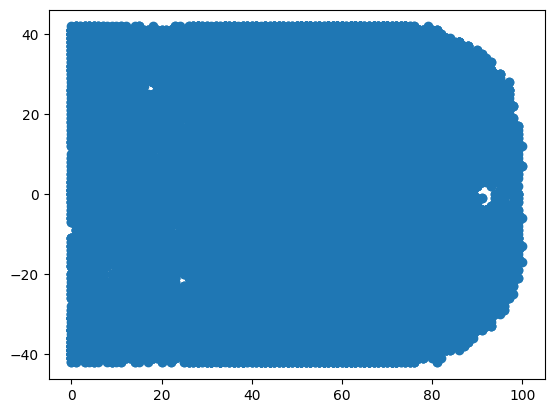

In [183]:
plt.plot(shots['x_coord'], shots['y_coord'], 'o')
plt.show()

In [192]:
# Every shot is plotted on one half of the ice, the red line is at x = 0, the blue line is at x = 25, goal line at x = 89, all measurements are in feet.
# Use this information to create an angle to the net feature
def angle(x_coord, y_coord):
    x_centered = 89 - x_coord
    return round(np.degrees(np.arctan(y_coord/x_centered)), 2)

shots['angles'] = angle(shots['x_coord'], shots['y_coord'])
shots['goal'] = np.where(shots['shot_class'] == 'goal', 1, 0)
shots.drop('shot_class', axis=1, inplace=True)
shots.head()
shots['rebound'].value_counts()
shots['rush'].value_counts()
shots['home_skaters'].value_counts()
shots['away_skaters'].value_counts()

home     last_play  rebound  rush home_skaters away_skaters  x_coord  \
0     1      giveaway        0     1            5            5       77   
1     1           hit        0     0            5            5       30   
2     0  shot-on-goal        0     0            5            5       35   
3     1           hit        0     0            5            5       41   
4     1           hit        0     0            5            5       46   

   y_coord  assist1  assist2 shot_type  angles  goal  
0        6        0        0     wrist   26.57     0  
1       30        0        0      slap   26.95     0  
2       30        0        0     wrist   29.05     0  
3       14        0        0     wrist   16.26     0  
4       17        0        0     wrist   21.57     0

rebound
0    306391
1     31437
Name: count, dtype: int64

rush
0    326163
1     11665
Name: count, dtype: int64

home_skaters
5    296460
4     31489
3      4362
6      3831
1       874
0       812
Name: count, dtype: int64

away_skaters
5    293771
4     34005
3      4722
6      3644
0       874
1       812
Name: count, dtype: int64

In [193]:
numerical_cols = shots[['home','rebound','rush','home_skaters','away_skaters','x_coord','y_coord', 'angles', 'goal']]
numerical_cols.head()
numerical_cols.corr().style.background_gradient(cmap='coolwarm')

home  rebound  rush home_skaters away_skaters  x_coord  y_coord  angles  \
0     1        0     1            5            5       77        6   26.57   
1     1        0     0            5            5       30       30   26.95   
2     0        0     0            5            5       35       30   29.05   
3     1        0     0            5            5       41       14   16.26   
4     1        0     0            5            5       46       17   21.57   

   goal  
0     0  
1     0  
2     0  
3     0  
4     0

In [194]:
# None of the numerical features above are too correlated, shot angle and y coordinate are which makes sense.
profile = ProfileReport(shots, title='Shots Profiling Report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [195]:
# Perform 80/20 training/test split and stratify based on loan approval
from sklearn.model_selection import train_test_split
strat_train_set, strat_test_set = train_test_split(shots, test_size=0.20, stratify=shots['goal'], random_state=42)
strat_train_set["goal"].value_counts() / len(strat_train_set)
strat_test_set["goal"].value_counts() / len(strat_test_set)
shots_train = strat_train_set.drop(['goal'], axis=1)
property = strat_train_set["goal"].copy()

goal
0    0.931293
1    0.068707
Name: count, dtype: float64

goal
0    0.931297
1    0.068703
Name: count, dtype: float64